#### AIM: represent HeCaToS molecules in a chemical spce to see if it possible to split them 

In [1]:
from flask import Flask, render_template
app = Flask( __name__ )

from rdkit import Chem
from rdkit.Chem import PandasTools
from rdkit.Chem.Draw import MolDraw2DSVG
from rdkit.Chem.Draw import rdMolDraw2D
from rdkit.Chem import rdDepictor, Descriptors, AllChem, DataStructs
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
import pickle

from sqlalchemy import create_engine

PandasTools.RenderImagesInAllDataFrames()

from rdkit.Chem.Draw import IPythonConsole

import matplotlib as plt

In [2]:
def calc_fp_arr( mols ):
    fplist = []
    for mol in mols:
        arr = np.zeros( (1,) )
        fp = AllChem.GetMorganFingerprintAsBitVect( mol, 2 )
        DataStructs.ConvertToNumpyArray( fp, arr )
        fplist.append( arr )
    return np.asarray( fplist )

### Database connexion

In [3]:
# Personal login details in correct format for sqlalchemy

with open('/Users/nbosc/notebooks/alchemy_nbosc_login.txt', 'r') as f:
    engine = create_engine(f.read())

### Get HeCaToS molecules

In [23]:
df_cpd = pd.read_excel('hecatos_all_versions_22.xlsx')

In [24]:
df_cpd.head()

,PARENT_PREF_NAME,PARENT_MOLREGNO,PARENT_CHEMBL_ID,VERSION_MOLREGNO,VERSION_CHEMBL_ID,ACTIVE_FORM,HECATOS_CATEGORY
0,ACETAMINOPHEN,16450,CHEMBL112,16450,CHEMBL112,0,HEPATOTOXIC
1,AMIODARONE,27185,CHEMBL633,27185,CHEMBL633,0,CARDIOTOXIC
2,AMIODARONE,27185,CHEMBL633,630439,CHEMBL1083993,0,CARDIOTOXIC
3,AZATHIOPRINE,431141,CHEMBL1542,431141,CHEMBL1542,0,HEPATOTOXIC
4,AZATHIOPRINE,431141,CHEMBL1542,674351,CHEMBL1200400,0,HEPATOTOXIC


In [9]:
df_cpd.PARENT_MOLREGNO.nunique()

42

In [10]:
query = '''
SELECT
    a.molregno
    , canonical_smiles
    , mw_freebase
FROM
    chembl_23.compound_structures a JOIN chembl_23.compound_properties b ON a.molregno = b.molregno
WHERE
    a.molregno IN {}
'''
df_smiles = pd.read_sql(query.format(tuple(df_cpd.PARENT_MOLREGNO.unique())), engine)

#### Infliximab -> antibody = no structure

In [11]:
df_smiles.shape

(41, 3)

In [12]:
PandasTools.AddMoleculeColumnToFrame(df_smiles, smilesCol='canonical_smiles', molCol='mol')

,molregno,canonical_smiles,mw_freebase,mol
0,921,OC1=NC(=O)C(N1)(c2ccccc2)c3ccccc3,252.27,
1,1114,COc1cccc2C(=O)c3c(O)c4C[C@](O)(C[C@H](O[C@H]5C[C@H](N)[C@@H](O)[C@H](C)O5)c4c(O)c3C(=O)c12)C(=O)CO,543.52,
2,1280,CC(=O)Oc1ccccc1C(=O)O,180.16,
3,1615,CC1(C)S[C@@H]2[C@H](NC(=O)Cc3ccccc3)C(=O)N2[C@H]1C(=O)O,334.39,
4,2217,CCC1(C(=O)NC(=O)NC1=O)c2ccccc2,232.24,

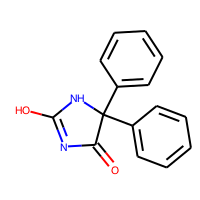
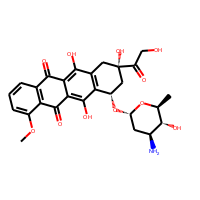
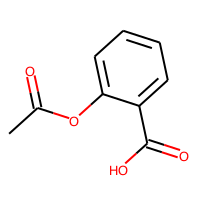
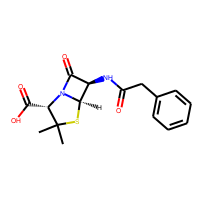
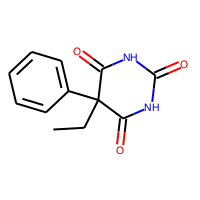

In [13]:
df_smiles.head()

#### So I want to run this function getsvgtext which does not do anything special, but it fails for some molecules with ValueError: Bad Conformer Id

In [14]:
def getsvgtext( mol ):
    d2d = rdMolDraw2D.MolDraw2DSVG(200,200)
    d2d.DrawMolecule( mol )
    d2d.FinishDrawing()
    svg = d2d.GetDrawingText()
    return svg.replace( "svg:","" )

In [15]:
[getsvgtext(m) for m in df_smiles['mol']]

ValueError: Bad Conformer Id

#### I can identifify the molecules using EmdedMolecule 

In [16]:
i=0
for m in df_smiles.mol:
    print(i, AllChem.EmbedMolecule(m))
    try:
        getsvgtext(m)
    except:
        print('error')
    i+=1

0 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
8 -1
error
9 0
10 -1
error
11 0
12 -1
error
13 0
14 0
15 0
16 0
17 0
18 0
19 0
20 0
21 -1
error
22 0
23 0
24 0
25 0
26 -1
error
27 0
28 0
29 -1
error
30 0
31 0
32 -1
error
33 0
34 0
35 0
36 0
37 0
38 0
39 0
40 -1
error


In [17]:
drugs = [mol for mol in df_smiles.mol]

In [18]:
drugfparr = calc_fp_arr( drugs )

In [19]:
#do PCA
pca = PCA( n_components=2 )
pca.fit( drugfparr ) 

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [20]:
drugsX = pca.transform( drugfparr )

In [21]:
df_smiles['PCA1'] = [x[0] for x in drugsX]
df_smiles['PCA2'] = [x[1] for x in drugsX]


#### The molecules are now in 3D.... 

,molregno,canonical_smiles,mw_freebase,mol,PCA1,PCA2
0,921,OC1=NC(=O)C(N1)(c2ccccc2)c3ccccc3,252.27,,-0.739158,-0.436161
1,1114,COc1cccc2C(=O)c3c(O)c4C[C@](O)(C[C@H](O[C@H]5C[C@H](N)[C@@H](O)[C@H](C)O5)c4c(O)c3C(=O)c12)C(=O)CO,543.52,,6.314952,-1.588791
2,1280,CC(=O)Oc1ccccc1C(=O)O,180.16,,-0.598760,0.109147
3,1615,CC1(C)S[C@@H]2[C@H](NC(=O)Cc3ccccc3)C(=O)N2[C@H]1C(=O)O,334.39,,-0.592195,0.103793
4,2217,CCC1(C(=O)NC(=O)NC1=O)c2ccccc2,232.24,,-0.965802,-0.371775

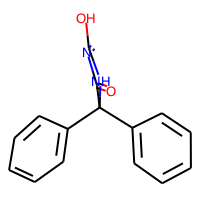
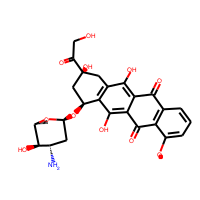
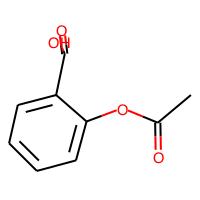
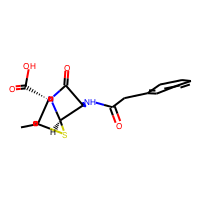
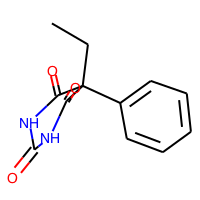

In [22]:
df_smiles.head()

In [62]:
df_cpd.drop_duplicates(subset=['PARENT_PREF_NAME']).head()

,PARENT_PREF_NAME,PARENT_MOLREGNO,PARENT_CHEMBL_ID,VERSION_MOLREGNO,VERSION_CHEMBL_ID,ACTIVE_FORM,HECATOS_CATEGORY
0,ACETAMINOPHEN,16450,CHEMBL112,16450,CHEMBL112,0,HEPATOTOXIC
1,AMIODARONE,27185,CHEMBL633,27185,CHEMBL633,0,CARDIOTOXIC
3,AZATHIOPRINE,431141,CHEMBL1542,431141,CHEMBL1542,0,HEPATOTOXIC
6,CELECOXIB,18694,CHEMBL118,389859,CHEMBL395268,0,CARDIOTOXIC
9,CLAVULANIC ACID,44876,CHEMBL777,3741,CHEMBL8290,0,HEPATOTOXIC


In [64]:
df = df_smiles.merge(df_cpd.drop_duplicates(subset=['PARENT_PREF_NAME'])[['PARENT_PREF_NAME','PARENT_MOLREGNO','PARENT_CHEMBL_ID', 'HECATOS_CATEGORY']], left_on='molregno', right_on='PARENT_MOLREGNO')